In [1]:
import torch
from transformers import BertModel, BertTokenizerFast, get_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from tools import DatasetProvider, EvaluateTools

/home/user/.pyenv/versions/3.8.20/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NOTE: Supply API token

Provide your huggingface API token (Readonly) so the superset model can be fetched. Also visit the following URL, login and accept the EULA of the model.

https://huggingface.co/datasets/manueltonneau/german-hate-speech-superset

## Running on Jupyterhub

Please supply your token via this env configuration.

%env HF_AUTH_TOKEN=<YOUR_TOKEN>

## Running locally

When running locally you can supply it via a .env file (see _.env.example_). 

In [ ]:
# Jupyterhub: INSERT HF TOKEN HERE

%env HF_AUTH_TOKEN=<YOUR_TOKEN>

In [2]:
# Load the model and tokenizer
model_name = "dbmdz/bert-base-german-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
base_model = BertModel.from_pretrained(model_name)

for param in base_model.parameters():
    param.requires_grad = False

In [3]:
# create the necessary loaders for a given dataset by encoding the text data
def train_encodings(X_train, X_test, y_train, y_test):
    train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors="pt")
    test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors="pt")

    train_labels = torch.tensor(y_train, dtype=torch.long)
    test_labels = torch.tensor(y_test, dtype=torch.long)

    class TextDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels
        
        def __getitem__(self, idx):
            item = {key: val[idx] for key, val in self.encodings.items()}
            item['labels'] = self.labels[idx]
            return item
        
        def __len__(self):
            return len(self.labels)

    train_dataset = TextDataset(train_encodings, train_labels)
    test_dataset = TextDataset(test_encodings, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False) # shuffle=True was before, set it to False because i shuffle anyways in the dataset fetch
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    return train_loader, test_loader

In [4]:
class CustomBertClassifier(nn.Module):
    def __init__(self, base_model, num_labels=2, hidden_size=768, intermediate_size=512, dropout_prob=0.3):
        super(CustomBertClassifier, self).__init__()
        self.bert = base_model
        
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.bn1 = nn.BatchNorm1d(intermediate_size)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.fc2 = nn.Linear(intermediate_size, intermediate_size // 2)
        self.bn2 = nn.BatchNorm1d(intermediate_size // 2)
        self.activation2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        
        # Final classifier layer
        self.classifier = nn.Linear(intermediate_size // 2, num_labels)
        
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            # Pass through BERT to get embeddings, no gradient
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the [CLS] token's representation
        cls_output = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, hidden_size)
        
        x = self.fc1(cls_output)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        
        # Final classification layer
        logits = self.classifier(x)  # shape: (batch_size, num_labels)
        
        return logits


In [5]:
# Create the model
num_labels = 2
model = CustomBertClassifier(base_model, num_labels=num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomBertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [ ]:
# Create the optimizer and learning rate scheduler that adjusts the learning rate during training
def init_optimizer(train_loader, num_epochs):
    optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=5e-5, weight_decay=0.01)
    
    num_training_steps = len(train_loader) * num_epochs
    lr_scheduler = get_scheduler(
        name="cosine", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps
    )
    return lr_scheduler, optimizer

In [ ]:
# weighted loss function, boost weight for 0 because model had a very low precision (false positives, guessing incorrectly that smth is offensive)
class_weights = [1.5, 1.0]
class_weights_tensor = torch.tensor(class_weights).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
# train the model on one batch
def infer_batch(batch):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # forward pass
    logits = model(input_ids, attention_mask=attention_mask)

    # compute loss using weighted CrossEntropyLoss
    loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

    return loss, logits

In [7]:
# evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            loss, logits = infer_batch(batch)
            
            test_loss += loss.item()
    
    return test_loss / len(test_loader)

In [8]:
# Train the model on the training set
def train_model(train_loader, test_loader, optimizer, lr_scheduler, num_epochs = 3):
    model.train()
    training_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        epoch_training_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            optimizer.zero_grad()

            loss, logits = infer_batch(batch)
            
            loss.backward()
            optimizer.step()
            
            epoch_training_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})
        
        lr_scheduler.step()  # Adjust learning rate

        # Average training loss for the epoch
        training_losses.append(epoch_training_loss / len(train_loader))

        # Evaluate on the test set
        test_loss = evaluate_model(model, test_loader)
        test_losses.append(test_loss)

    return training_losses, test_losses

In [9]:
# plot the training and test loss curves
def plot_training_curves(num_epochs, training_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Test Loss')
    plt.legend()
    plt.show()

In [10]:
# get the predictions of the model on the test set
def get_predictions(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=-1).cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)

    return predictions, true_labels

# Training on Germ Eval 18

In [11]:
dataset_name="philschmid/germeval18"
dataset_germeval = DatasetProvider.get_germ_eval_18(dataset_name, num_samples=5000)
DatasetProvider.stats(dataset_germeval)

Sample Data:
{'text': '@corinnamilborn Liebe Corinna, wir würden dich gerne als Moderatorin für uns gewinnen! Wärst du begeisterbar?', 'label': 0}

Data Length:
8407
Number of labels with 1: 2838
Number of labels with 0: 5569


In [12]:
X_train, X_test, y_train, y_test = DatasetProvider.split_data(dataset_germeval)

Training samples: 6725, Test samples: 1682


In [13]:
train_loader, test_loader = train_encodings(X_train, X_test, y_train, y_test)

In [14]:
num_epochs = 250
lr_scheduler, optimizer = init_optimizer(train_loader, num_epochs)
training_losses, test_losses = train_model(train_loader, test_loader, optimizer, lr_scheduler, num_epochs=num_epochs)

Epoch 1/3:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 3/3: 100%|██████████| 421/421 [01:23<00:00,  5.05it/s, loss=0.631]


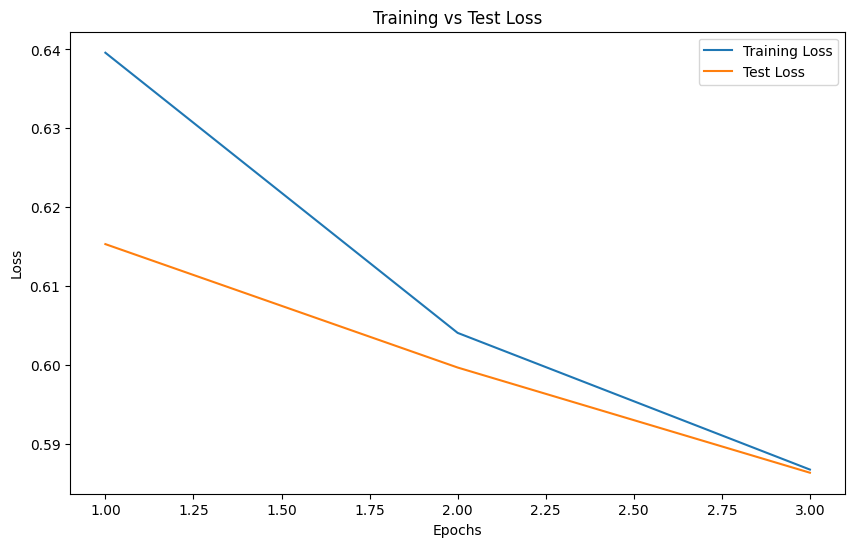

In [15]:
plot_training_curves(num_epochs, training_losses, test_losses)

Model Evaluation Metrics:
Accuracy: 0.6706
Precision: 0.0827
Recall: 0.5875
F1 Score: 0.1451


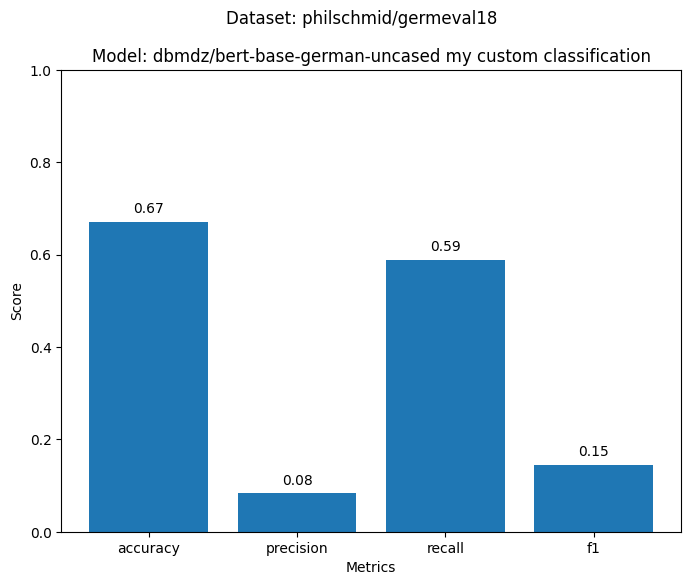

In [16]:
predictions, true_labels = get_predictions(model, test_loader)
metrics = EvaluateTools.calc_metrics(true_labels, predictions)
EvaluateTools.plot_metrics(metrics, model_name + ' my custom classification', dataset_name)

# Training on german superset

In [17]:
dataset_name = "manueltonneau/german-hate-speech-superset"
dataset_superset = DatasetProvider.get_superset(dataset_name, num_samples=40000)
DatasetProvider.stats(dataset_superset)

In [18]:
X_train, X_test, y_train, y_test = DatasetProvider.split_data(dataset_superset)

In [19]:
train_loader, test_loader = train_encodings(X_train, X_test, y_train, y_test)

In [20]:
num_epochs = 250
lr_scheduler, optimizer = init_optimizer(train_loader, num_epochs)
training_losses, test_losses = train_model(train_loader, test_loader, optimizer, lr_scheduler, num_epochs=num_epochs)

In [21]:
plot_training_curves(num_epochs, training_losses, test_losses)

In [22]:
predictions, true_labels = get_predictions(model, test_loader)
metrics = EvaluateTools.calc_metrics(true_labels, predictions)
EvaluateTools.plot_metrics(metrics, model_name + ' my custom classification', dataset_name)